In [14]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
import pandas as pd

import jax 
import jax_cosmo as jc
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Cosmology 
cosmo_jax = jc.Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8 = 0.8, n_s=0.96,
         Omega_k=0., w0=-1., wa=0.)

In [41]:
# Redshift range
zmin = 0.0
zmax = 0.5
zstep = 0.001
zvec = np.arange(zmin, zmax, zstep)

# Smail Parameters
a_smail= 1.64e0
b_smail = 3.73e0
z0_smail = 4.1e-1

# Scale factor 
a = 1 / (1+zvec)

# Ell range 
ell_range = np.arange(1, 1e3)
ell_value_test = 10

In [51]:
# Redshift distribution 
nz = jc.redshift.smail_nz(a_smail, b_smail, z0_smail)

# Tracers 
velocity_tracer = jc.probes.PeculiarVelocity([nz])
galaxy_tracer = jc.probes.NumberCounts([nz], jc.bias.constant_linear_bias(1.0))  

# Window function
window_vv = velocity_tracer.kernel(cosmo_jax, zvec, ell_range)

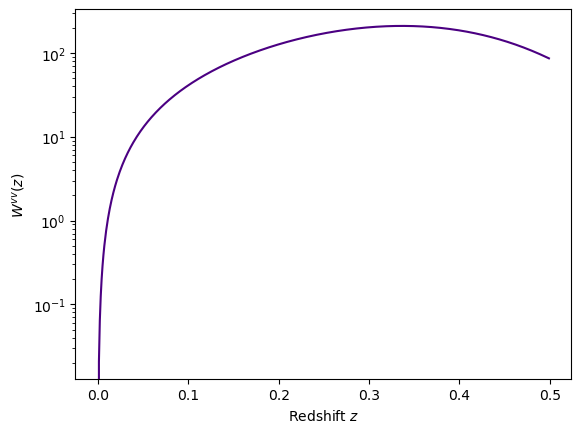

In [52]:
plt.plot(zvec, window_vv[0], ls='-', color='indigo')
plt.yscale('log')
plt.xlabel('Redshift $z$');
plt.ylabel('$W^{vv}(z)$');

In [53]:
# Velocity Cell - with Limber approximation
cell_vv = jc.angular_cl.angular_cl(cosmo_jax, ell_range, [velocity_tracer])

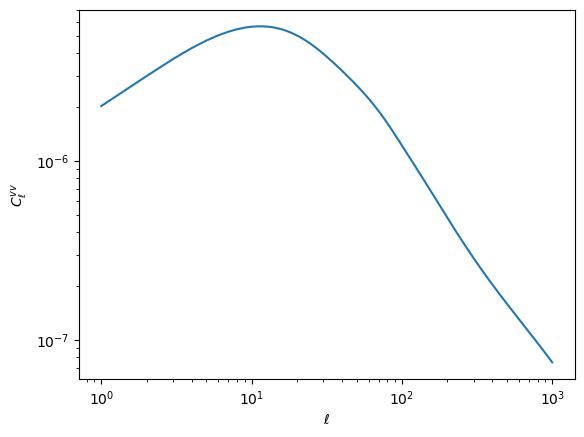

In [54]:
# Cell plot 
plt.plot(ell_range, cell_vv[0])
plt.loglog()
plt.xlabel('$\ell$')
plt.ylabel('$C_{\ell}^{vv}$');